In [8]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#from tensorflow.keras import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:

file = '../data/processed/British Columbia_combined.csv'
series = read_csv(file, index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
series = series.iloc[-30:]

<AxesSubplot:xlabel='Date'>

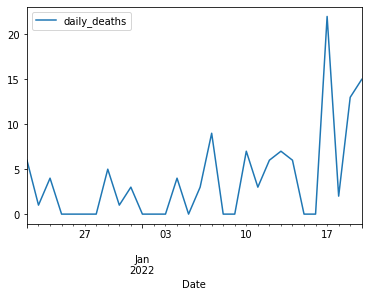

In [22]:
series.plot()

### Hyperparameter tuning

The parameters we need to tune in our LSTM deep learning model are 
1. Number of training epochs
2. Number of batches
3. Number of neurons

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0) TrainRMSE=2.550566, TestRMSE=8.654548
1) TrainRMSE=2.496975, TestRMSE=8.444867
2) TrainRMSE=3.277439, TestRMSE=9.046120
3) TrainRMSE=2.454002, TestRMSE=8.317083
4) TrainRMSE=2.493693, TestRMSE=8.352692
5) TrainRMSE=2.470692, TestRMSE=8.571670
6) TrainRMSE=2.978632, TestRMSE=8.760743
7) TrainRMSE=3.153999, TestRMSE=8.842809
8) TrainRMSE=2.480176, TestRMSE=8.506679
9) TrainRMSE=2.567019, TestRMSE=8.698895


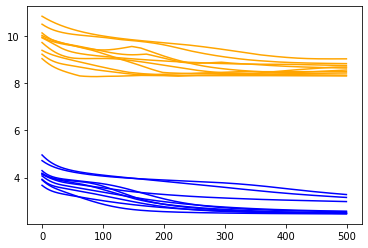

In [29]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df = df.drop(0)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
	# separate
	X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
	# reshape
	reshaped = X.reshape(len(X), 1, 1)
	# forecast dataset
	output = model.predict(reshaped, batch_size=batch_size)
	# invert data transforms on forecast
	predictions = list()
	for i in range(len(output)):
		yhat = output[i,0]
		# invert scaling
		yhat = invert_scale(scaler, X[i], yhat)
		# invert differencing
		yhat = yhat + raw_data[i]
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
	return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# prepare model
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit model
	train_rmse, test_rmse = list(), list()
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
		# evaluate model on train data
		raw_train = raw[-(len(train)+len(test)+1):-len(test)]
		train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
		model.reset_states()
		# evaluate model on test data
		raw_test = raw[-(len(test)+1):]
		test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
		model.reset_states()
	history = DataFrame()
	history['train'], history['test'] = train_rmse, test_rmse
	return history

# run diagnostic experiments
def run():
    # load dataset
    series = read_csv(file, index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
    series = series.iloc[-36:]
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # config
    repeats = 10
    n_batch = 4
    n_epochs = 500
    n_neurons = 1
    # run diagnostic tests
    for i in range(repeats):
        history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('epochs_diagnostic.png')
 
# entry point
run()

In [35]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df = df.drop(0)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# run a repeated experiment
def experiment(repeats, series, epochs):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the model
		batch_size = 4
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, batch_size, epochs, 1)
		# forecast the entire training dataset to build up state for forecasting
		train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
		lstm_model.predict(train_reshaped, batch_size=batch_size)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=batch_size)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

In [36]:
# load dataset
#series = read_csv(file, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = read_csv(file, index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
series = series.iloc[-36:]
# experiment
repeats = 30
results = DataFrame()
# vary training epochs
epochs = [500, 1000, 2000, 4000, 6000]
for e in epochs:
	results[str(e)] = experiment(repeats, series, e)

1) Test RMSE: 8.457
2) Test RMSE: 8.484
3) Test RMSE: 8.377
4) Test RMSE: 8.457
5) Test RMSE: 8.499
6) Test RMSE: 8.769
7) Test RMSE: 8.444
8) Test RMSE: 8.386
9) Test RMSE: 8.455
10) Test RMSE: 8.388
11) Test RMSE: 8.760
12) Test RMSE: 8.540
13) Test RMSE: 8.846
14) Test RMSE: 8.852
15) Test RMSE: 8.864
16) Test RMSE: 8.872
17) Test RMSE: 8.383
18) Test RMSE: 8.843
19) Test RMSE: 8.451
20) Test RMSE: 8.501
21) Test RMSE: 8.487
22) Test RMSE: 8.852
23) Test RMSE: 8.814
24) Test RMSE: 8.437
25) Test RMSE: 8.337
26) Test RMSE: 8.402
27) Test RMSE: 8.359
28) Test RMSE: 8.430
29) Test RMSE: 8.572
30) Test RMSE: 8.902
1) Test RMSE: 8.337
2) Test RMSE: 8.367
3) Test RMSE: 11.470
4) Test RMSE: 8.288
5) Test RMSE: 8.226
6) Test RMSE: 8.319
7) Test RMSE: 8.299
8) Test RMSE: 8.642
9) Test RMSE: 8.521
10) Test RMSE: 8.488
11) Test RMSE: 8.302
12) Test RMSE: 8.519
13) Test RMSE: 8.788
14) Test RMSE: 8.641
15) Test RMSE: 8.266
16) Test RMSE: 8.650
17) Test RMSE: 8.960
18) Test RMSE: 8.422
19) Test 

In [37]:
results.describe()

,500,1000,2000,4000,6000
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,8.574037,8.585379,8.644790,8.557547,8.552302
std,0.197340,0.573501,0.706428,0.232026,0.342548
min,8.336822,8.226491,8.162554,8.088478,7.887393
25%,8.431846,8.339073,8.375899,8.388966,8.306328
50%,8.485315,8.494148,8.546171,8.538037,8.547723
75%,8.802508,8.638210,8.676087,8.743079,8.804288
max,8.901949,11.469790,12.245225,9.045797,9.287915


<AxesSubplot:>

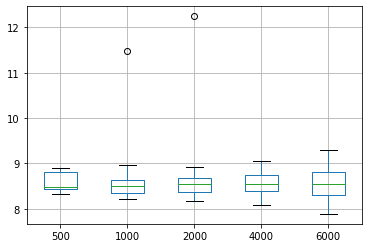

In [38]:
results.boxplot()

It appears that number of epochs doesnt have a significant difference. The mean and standard deviation values are lowest for epochs=500. Hence we will stick with that.

In [39]:
# run a repeated experiment
def experiment(repeats, series, batch_size):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the model
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, batch_size, 1000, 1)
		# forecast the entire training dataset to build up state for forecasting
		train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
		lstm_model.predict(train_reshaped, batch_size=batch_size)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=batch_size)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
    return error_scores


# load dataset
#series = read_csv(file, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# experiment
repeats = 30
results_batch = DataFrame()
# vary training batches
batches = [1, 2, 4]
for b in batches:
	results_batch[str(b)] = experiment(repeats, series, b)

1) Test RMSE: 9.066
2) Test RMSE: 8.640
3) Test RMSE: 9.500
4) Test RMSE: 8.804
5) Test RMSE: 8.704
6) Test RMSE: 8.708
7) Test RMSE: 8.687
8) Test RMSE: 8.677
9) Test RMSE: 8.799
10) Test RMSE: 8.404
11) Test RMSE: 8.982
12) Test RMSE: 8.904
13) Test RMSE: 8.978
14) Test RMSE: 8.977
15) Test RMSE: 8.854
16) Test RMSE: 9.069
17) Test RMSE: 8.837
18) Test RMSE: 8.858
19) Test RMSE: 9.313
20) Test RMSE: 8.671
21) Test RMSE: 9.122
22) Test RMSE: 8.695
23) Test RMSE: 8.856
24) Test RMSE: 9.174
25) Test RMSE: 8.518
26) Test RMSE: 8.846
27) Test RMSE: 8.647
28) Test RMSE: 8.883
29) Test RMSE: 8.799
30) Test RMSE: 8.799
1) Test RMSE: 9.189
2) Test RMSE: 9.013
3) Test RMSE: 8.587
4) Test RMSE: 9.118
5) Test RMSE: 9.737
6) Test RMSE: 8.776
7) Test RMSE: 8.662
8) Test RMSE: 8.547
9) Test RMSE: 8.691
10) Test RMSE: 9.162
11) Test RMSE: 8.994
12) Test RMSE: 9.138
13) Test RMSE: 8.386
14) Test RMSE: 9.012
15) Test RMSE: 8.977
16) Test RMSE: 8.648
17) Test RMSE: 9.183
18) Test RMSE: 8.915
19) Test R

In [40]:
results_batch.describe()

,1,2,4
count,30.000000,30.000000,30.000000
mean,8.858997,8.937836,8.609733
std,0.229036,0.277693,0.371991
min,8.403653,8.386452,8.250777
25%,8.696958,8.757100,8.396842
50%,8.841484,8.982686,8.510518
75%,8.977458,9.134513,8.731265
max,9.499968,9.737039,10.110613


<AxesSubplot:>

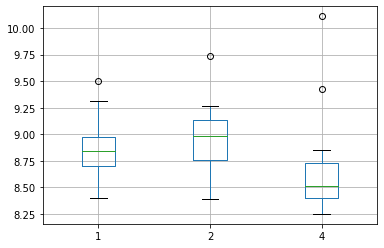

In [41]:
results_batch.boxplot()

In [42]:
...

# run a repeated experiment
def experiment(repeats, series, neurons):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the model
		batch_size = 4
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, batch_size, 1000, neurons)
		# forecast the entire training dataset to build up state for forecasting
		train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
		lstm_model.predict(train_reshaped, batch_size=batch_size)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=batch_size)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores


# load dataset
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# experiment
repeats = 10
results_neurons = DataFrame()
# vary neurons
neurons = [1, 2, 3, 4, 5]
for n in neurons:
	results_neurons[str(n)] = experiment(repeats, series, n)


1) Test RMSE: 8.689
2) Test RMSE: 8.303
3) Test RMSE: 8.526
4) Test RMSE: 8.354
5) Test RMSE: 8.523
6) Test RMSE: 8.365
7) Test RMSE: 8.463
8) Test RMSE: 8.767
9) Test RMSE: 9.281
10) Test RMSE: 8.684
1) Test RMSE: 8.616
2) Test RMSE: 8.559
3) Test RMSE: 7.969
4) Test RMSE: 8.356
5) Test RMSE: 8.667
6) Test RMSE: 9.535
7) Test RMSE: 8.261
8) Test RMSE: 8.485
9) Test RMSE: 7.869
10) Test RMSE: 8.481
1) Test RMSE: 7.801
2) Test RMSE: 8.594
3) Test RMSE: 9.261
4) Test RMSE: 9.222
5) Test RMSE: 7.481
6) Test RMSE: 8.373
7) Test RMSE: 8.811
8) Test RMSE: 9.211
9) Test RMSE: 8.616
10) Test RMSE: 8.928
1) Test RMSE: 9.000
2) Test RMSE: 8.962
3) Test RMSE: 9.013
4) Test RMSE: 9.005
5) Test RMSE: 8.382
6) Test RMSE: 8.875
7) Test RMSE: 8.391
8) Test RMSE: 9.912
9) Test RMSE: 8.462
10) Test RMSE: 10.741
1) Test RMSE: 10.062
2) Test RMSE: 7.655
3) Test RMSE: 10.302
4) Test RMSE: 8.181
5) Test RMSE: 9.295
6) Test RMSE: 9.924
7) Test RMSE: 9.162
8) Test RMSE: 10.102
9) Test RMSE: 9.511
10) Test RMS

In [43]:
# summarize results
results_neurons.describe()

,1,2,3,4,5
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,8.595522,8.479641,8.629787,9.074469,9.191187
std,0.286823,0.455852,0.603915,0.735393,1.001452
min,8.303140,7.868559,7.480832,8.382359,7.654852
25%,8.389448,8.284493,8.428434,8.565407,8.426106
50%,8.524485,8.483180,8.713305,8.981319,9.403037
75%,8.687762,8.601697,9.139903,9.011051,10.027493
max,9.280908,9.534540,9.261316,10.741087,10.302293


<AxesSubplot:>

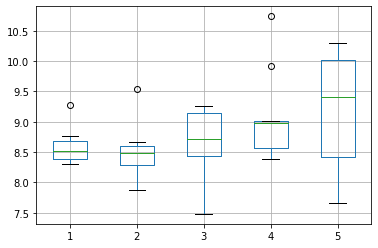

In [45]:

results_neurons.boxplot()


As per the above results, I have decided to go with neurons=2, batches=4 and epochs=500.

In [47]:
bc_deaths = pd.read_csv('../data/processed/British Columbia_combined.csv', index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
bc_deaths

,daily_deaths
Date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
...,...
2022-01-16,0.0
2022-01-17,22.0
2022-01-18,2.0


In [49]:
dataset = bc_deaths.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

In [50]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

            daily_deaths
Date                    
2020-01-22           0.0
2020-01-23           0.0
2020-01-24           0.0
2020-01-25           0.0
2020-01-26           0.0


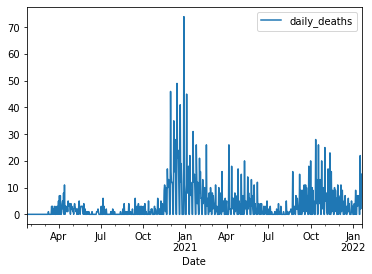

In [33]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

#series = read_csv('../data/processed/British Columbia_combined.csv', index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

In [51]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')

In [2]:
bc_deaths = pd.read_csv('../data/processed/British Columbia_combined.csv', index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
bc_deaths

,daily_deaths
Date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
...,...
2022-01-16,0.0
2022-01-17,22.0
2022-01-18,2.0


In [3]:
dataset = bc_deaths.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

694

In [68]:
# Scale the data
def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return scaler,scaled_data




In [75]:
# R
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [86]:
# Create the training data set 
# Create the scaled training data set
def create_train_test_data(scaled_data):
    train_data = scaled_data[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(14, len(train_data)):
        x_train.append(train_data[i-14:i, 0])
        y_train.append(train_data[i, 0])

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    test_data = scaled_data[training_data_len - 14: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(14, len(test_data)):
        x_test.append(test_data[i-14:i, 0])

    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    
    return x_train, x_test

x_train, x_test = create_train_test_data(scaled_data)

In [ ]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

def fit_lstm(x_train, y_train, batch_size=1, num_epochs=1):
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs)
    
    return model

model = fit_lstm(x_train, y_train, 1, 1)

680/680 [==============================] - 261s 384ms/sample - loss: 0.0077


In [ ]:
# run a repeated experiment
def experiment(repeats, series, epochs):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the model
		batch_size = 4
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, batch_size, epochs, 1)
		# forecast the entire training dataset to build up state for forecasting
		train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
		lstm_model.predict(train_reshaped, batch_size=batch_size)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=batch_size)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

repeats = 30
results = DataFrame()
# vary training epochs
epochs = [500, 1000, 2000, 4000, 6000]
for e in epochs:
	results[str(e)] = experiment(repeats, series, e)

In [90]:
def experiment(repeats, df, epochs):
    
    dataset = bc_deaths.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    
    scaler, scaled_data = scale_data(dataset)
    
    x_train, x_test = create_train_test_data(scaled_data)
    
    
    # run experiment
    error_scores = list()
    for r in range(repeats):
        batch_size = 1
        model = fit_lstm(x_train, y_train, batch_size, epochs)
        # Get the models predicted price values 
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)

        # Get the root mean squared error (RMSE)
        rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
        error_scores.append(rmse)
    return error_scores

In [91]:
repeats = 10
results = DataFrame()
results['1'] = experiment(repeats, bc_deaths, 1)

680/680 [==============================] - 263s 386ms/sample - loss: 0.0076


In [92]:
results

,1
0,4.548261


In [87]:


# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

4.480428999560868

In [57]:
test_data = scaled_data[training_data_len - 14: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(14, len(test_data)):
    x_test.append(test_data[i-14:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

4.628571167627163

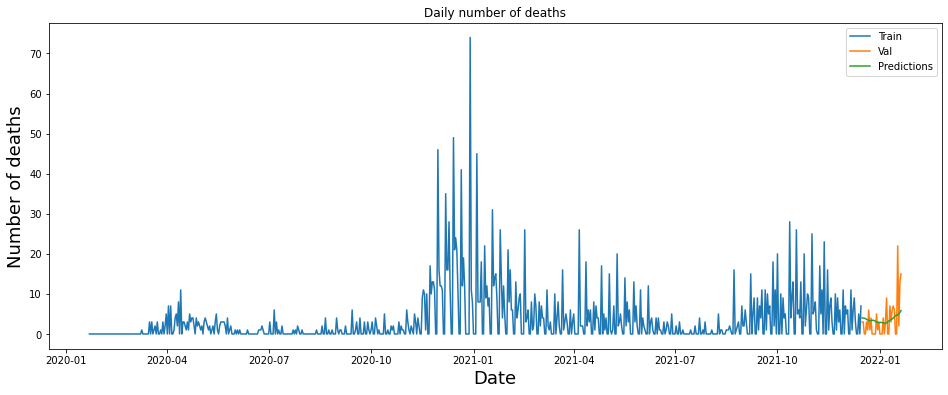

In [88]:
# Plot the data
train = bc_deaths[:training_data_len]
valid = bc_deaths[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Daily number of deaths')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of deaths', fontsize=18)
plt.plot(train['daily_deaths'])
plt.plot(valid[['daily_deaths', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()

In [ ]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df = df.drop(0)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
	# separate
	X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
	# reshape
	reshaped = X.reshape(len(X), 1, 1)
	# forecast dataset
	output = model.predict(reshaped, batch_size=batch_size)
	# invert data transforms on forecast
	predictions = list()
	for i in range(len(output)):
		yhat = output[i,0]
		# invert scaling
		yhat = invert_scale(scaler, X[i], yhat)
		# invert differencing
		yhat = yhat + raw_data[i]
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
	return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# prepare model
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit model
	train_rmse, test_rmse = list(), list()
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
		# evaluate model on train data
		raw_train = raw[-(len(train)+len(test)+1):-len(test)]
		train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
		model.reset_states()
		# evaluate model on test data
		raw_test = raw[-(len(test)+1):]
		test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
		model.reset_states()
	history = DataFrame()
	history['train'], history['test'] = train_rmse, test_rmse
	return history

# run diagnostic experiments
def run():
    # load dataset
    series = read_csv(file, index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
    series = series.iloc[-36:]
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # config
    repeats = 10
    n_batch = 4
    n_epochs = 500
    n_neurons = 1
    # run diagnostic tests
    for i in range(repeats):
        history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('epochs_diagnostic.png')
 
# entry point
run()